## Problem statement:
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [2]:
# Mount Google Drive to download and unzip the dataset
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Unzip the dataset
!unzip "/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration.zip" > /dev/null

In [5]:
# Libraries Import
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

import PIL


In [6]:
# Train and Test Directories

dir_train = pathlib.Path("/content/Train/")
dir_test = pathlib.Path("/content/Test/")

# Data Understanding

In [7]:
# Train and test dataset image count

#Train Image count
image_count_train = len(list(dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


# Dataset Creation
- Create train & validation dataset from the train directory with a batch size of 32.
- Resizing images to 180*180.

**Data Visualization**

Found 2239 files belonging to 9 classes.


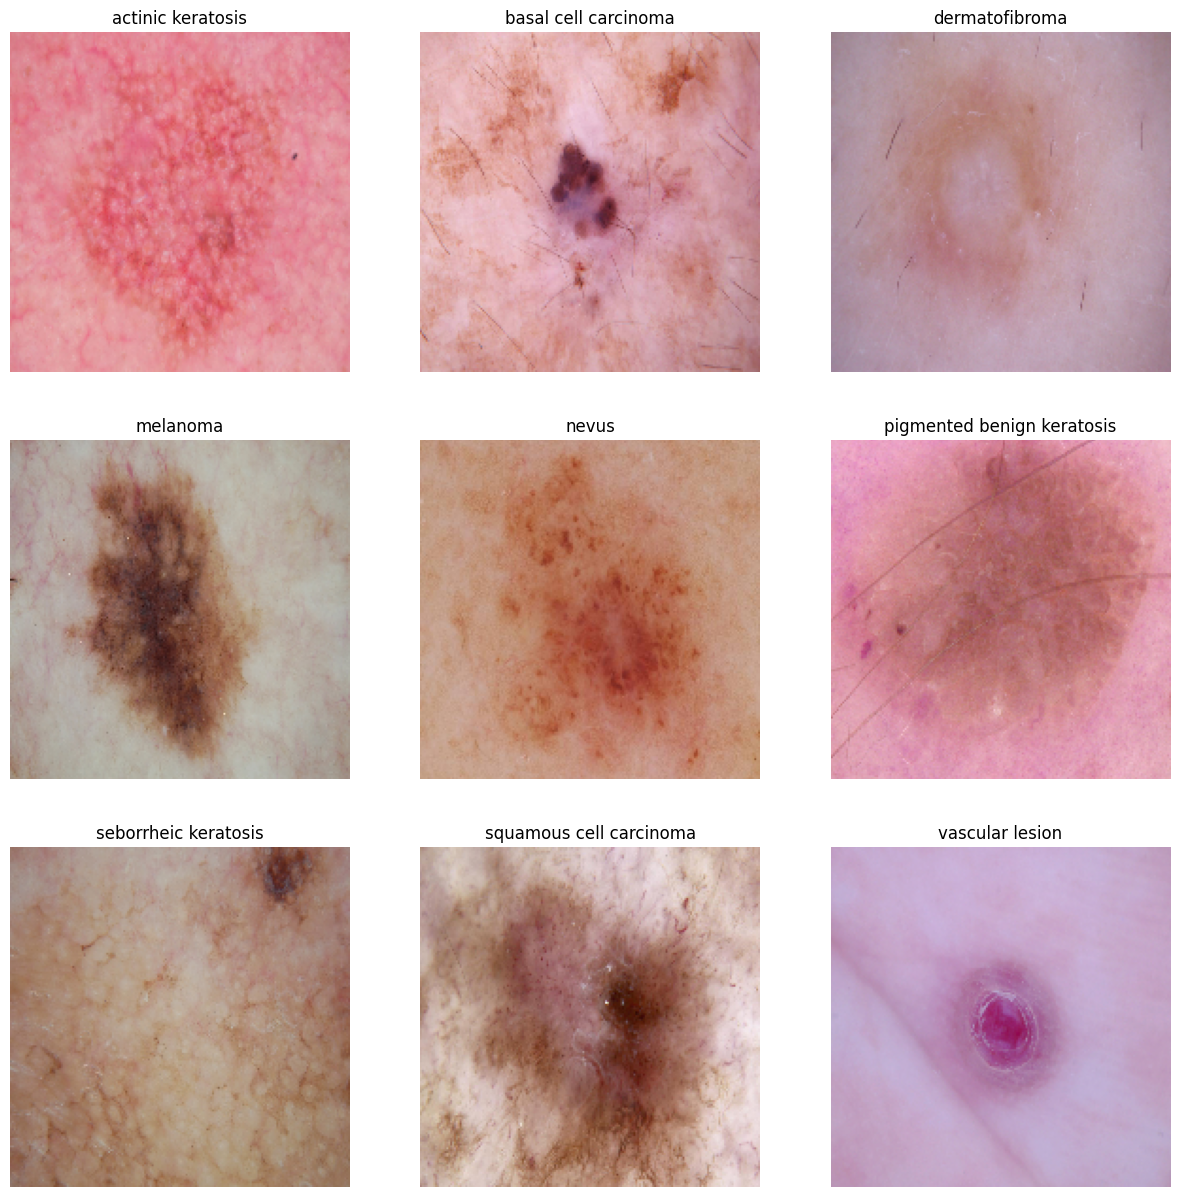

In [8]:
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

# Skin Cancer classes
class_names = image_dataset.class_names

files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(dir_train)+'/'+c+'/'+x,os.listdir(str(dir_train)+'/'+c)))



# Dataset visualisation

In [ ]:
# Visualize one instance of all the class present in the dataset.
# Image plots
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

# Visualizing distribution of classes in the training dataset.

In [9]:
def class_distribution_count(directory):

    # Image count in each class
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(dir_train)
df

,Class,No. of Image
0,actinic keratosis,114
1,melanoma,438
2,seborrheic keratosis,77
3,basal cell carcinoma,376
4,squamous cell carcinoma,181
5,pigmented benign keratosis,462
6,dermatofibroma,95
7,vascular lesion,139
8,nevus,357


<Axes: xlabel='No. of Image', ylabel='Class'>

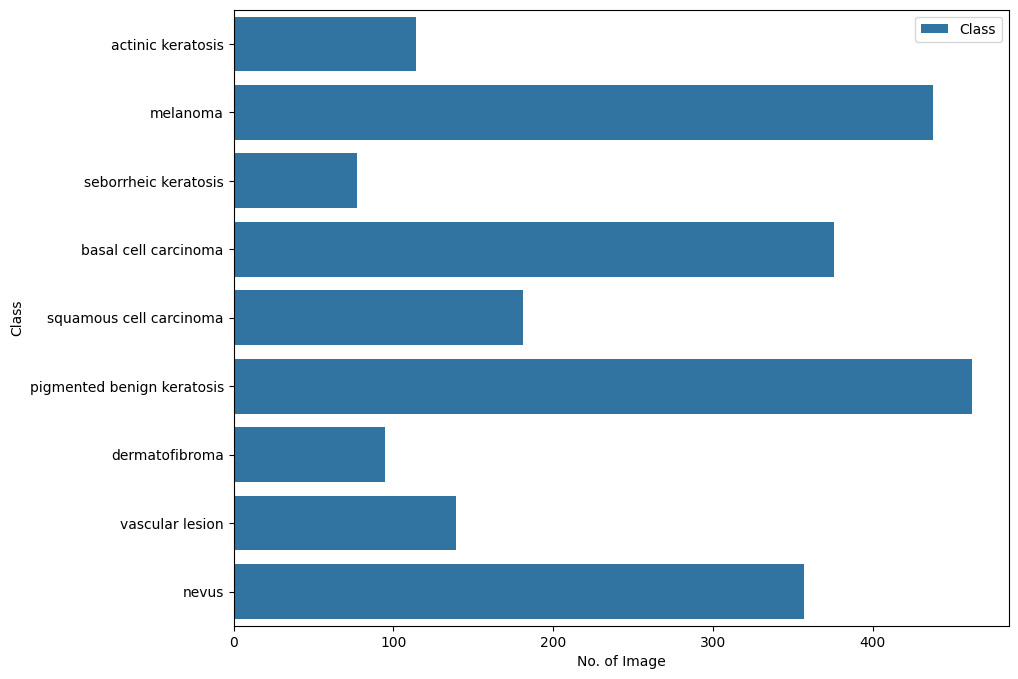

In [10]:
# Plot number of images in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

# Resolve underfitting/overfitting

To address the issue of class imbalance, we can use the Python package Augmentor (https://augmentor.readthedocs.io/en/master/) to enhance the dataset. This package allows us to increase the number of samples in all classes, ensuring that no class is underrepresented.

In [11]:
# Install Augmentor
!pip install Augmentor

In [12]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(dir_train + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BE7583E0730>: 100%|██████████| 500/500 [00:19<00:00, 25.05 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BE75AF0FFA0>: 100%|██████████| 500/500 [00:21<00:00, 23.78 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7BE75ADEC4F0>: 100%|██████████| 500/500 [00:19<00:00, 25.30 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7BE75AD36920>: 100%|██████████| 500/500 [01:34<00:00,  5.29 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7BE758408A90>: 100%|██████████| 500/500 [01:30<00:00,  5.50 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BE7517EFB20>: 100%|██████████| 500/500 [00:19<00:00, 25.32 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7BE75ADC9A50>: 100%|██████████| 500/500 [00:44<00:00, 11.31 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BE75AF0F340>: 100%|██████████| 500/500 [00:19<00:00, 25.67 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BE75AD83A30>: 100%|██████████| 500/500 [00:20<00:00, 24.92 Samples/s]


In [13]:
# Augmentor Image Count
image_count_train = len(list(dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


**Model Building**

In [14]:
# Train Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)


Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [15]:
# Validation Dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [16]:
# AUTOTUNE automatically adjusts the number of processes to optimize throughput.

AUTOTUNE = tf.data.experimental.AUTOTUNE
# `Dataset.cache()` stores images in memory after initial loading from disk, speeding up subsequent access.

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# `Dataset.prefetch()` allows data preprocessing and model execution to occur simultaneously during training.
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# CNN Model Architecture

In [17]:
# Initialize the sequential model
model = Sequential()

# Add rescaling layer to normalize pixel values
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

# First convolutional layer
model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# Second convolutional layer
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# Third convolutional layer
model.add(layers.Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# Dropout layer to prevent overfitting, dropping 50% of units
model.add(layers.Dropout(0.5))

# Flatten layer to convert 3D feature maps to 1D feature vectors
model.add(layers.Flatten())

# Dense layer for learning non-linear combinations
model.add(layers.Dense(128, activation='relu'))

# Another dropout layer, this time dropping 25% of units
model.add(layers.Dropout(0.25))

# Output dense layer with softmax activation to output probabilities
model.add(layers.Dense(len(class_names), activation='softmax'))

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

# Model Visualization

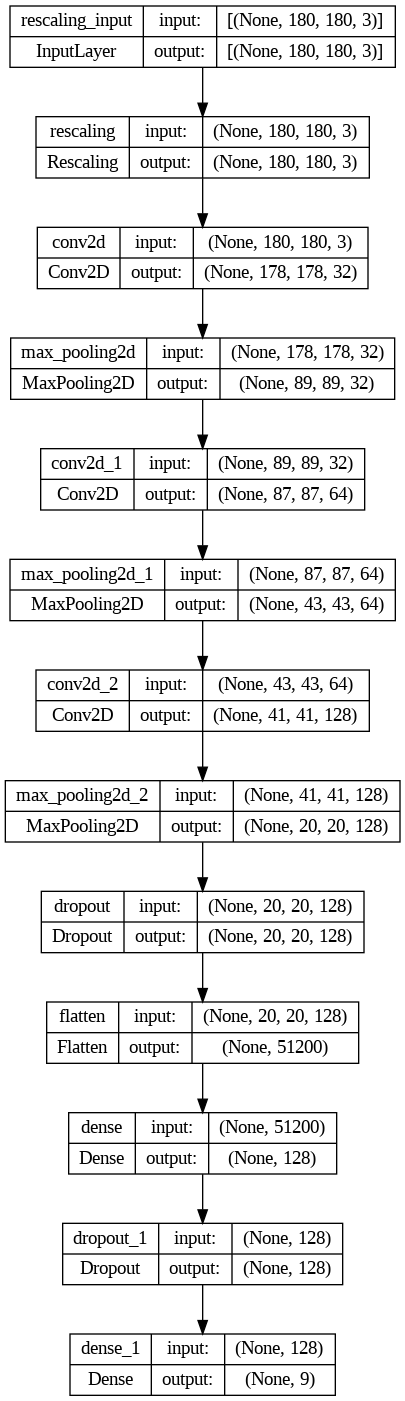

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# Model Compilation

In [19]:
# Adam optimizer: A method of stochastic gradient descent that adjusts learning rates based on estimates of first and second moments.
# categorical_crossentropy: A loss function for models with two or more output labels, useful for multi-class classification.

model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

# ModelCheckpoint: Saves the model or weights at specified intervals during training, allowing recovery and resumption.
checkpoint = ModelCheckpoint("model.h5", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

# EarlyStopping: Halts training when a monitored metric ceases to improve, preventing overfitting.
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

In [ ]:
# Model Training
epochs = 30
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
169/169 [==============================] - ETA: 0s - loss: 1.9392 - accuracy: 0.2598
Epoch 1: val_accuracy improved from -inf to 0.37342, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


169/169 [==============================] - 444s 2s/step - loss: 1.9392 - accuracy: 0.2598 - val_loss: 1.6460 - val_accuracy: 0.3734
Epoch 2/20
169/169 [==============================] - ETA: 0s - loss: 1.5279 - accuracy: 0.4236
Epoch 2: val_accuracy improved from 0.37342 to 0.46474, saving model to model.h5
169/169 [==============================] - 410s 2s/step - loss: 1.5279 - accuracy: 0.4236 - val_loss: 1.3987 - val_accuracy: 0.4647
Epoch 3/20
169/169 [==============================] - ETA: 0s - loss: 1.3786 - accuracy: 0.4766
Epoch 3: val_accuracy improved from 0.46474 to 0.56050, saving model to model.h5
169/169 [==============================] - 404s 2s/step - loss: 1.3786 - accuracy: 0.4766 - val_loss: 1.2188 - val_accuracy: 0.5605
Epoch 4/20
169/169 [==============================] - ETA: 0s - loss: 1.2360 - accuracy: 0.5458
Epoch 4: val_accuracy did not improve from 0.56050
169/169 [==============================] - 412s 2s/step - loss: 1.2360 - accuracy: 0.5458 - val_loss: 1

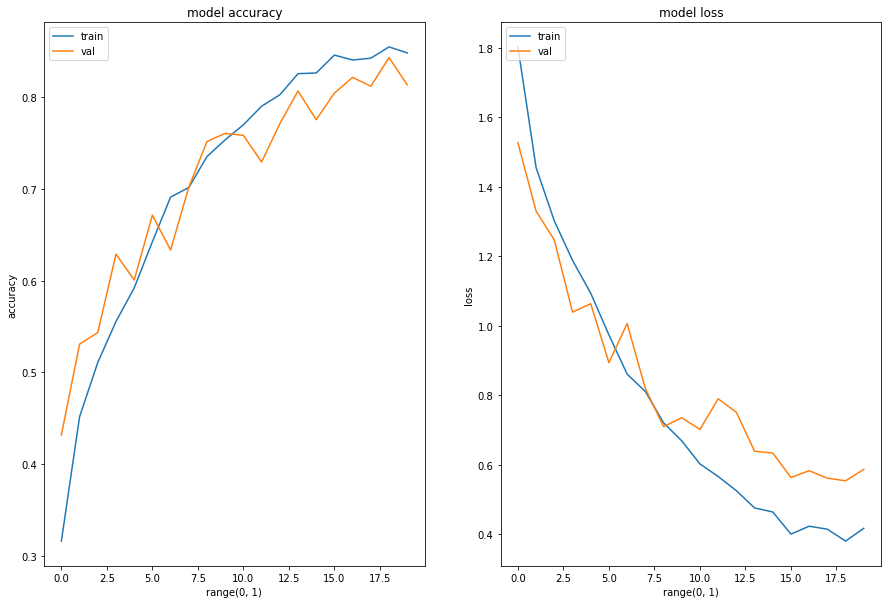

In [ ]:
# Plot the training curves

# Determine the range of epochs based on when EarlyStopping was triggered
epochs_range = range(earlystop.stopped_epoch + 1)

# Set up the plot with appropriate dimensions
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

# Plot Model Accuracy
# Compare training and validation accuracy across epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot Model Loss
# Compare training and validation loss across epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')

# Display the plots
plt.show()


## Model Prediction

Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


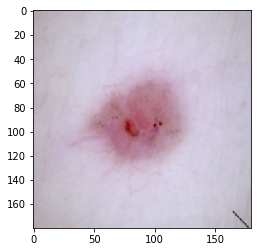

In [ ]:
from glob import glob

# Define the path to the test images for the second class
Test_image_path = os.path.join(dir_test, class_names[1], '*')

# Use glob to find all files matching the path pattern
Test_image = glob(Test_image_path)

# Load the last image in the list with a target size of 180x180 pixels with 3 color channels
Test_image = load_img(Test_image[-1], target_size=(180, 180, 3))

# Display the image using matplotlib
plt.imshow(Test_image)
plt.grid(False)  # Disable the grid for a cleaner display

# Expand the image dimensions to match the input shape expected by the model (batch size of 1)
img = np.expand_dims(Test_image, axis=0)

# Predict the class of the image using the model
pred = model.predict(img)

# Convert the probabilities to class index
pred = np.argmax(pred)

# Map the predicted class index to the class name
pred_class = class_names[pred]

# Print the actual and predicted class names
print("Actual Class " + class_names[1] + '\n' + "Predictive Class " + pred_class)